In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2


import numpy as np
from tqdm import trange, tqdm

# needed otherwise imshow kills kernel
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
import math
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

from diffusion import UNet, MNISTDiffusion, ExponentialMovingAverage

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('./MNIST/raw/train-images-idx3-ubyte', 'rb') as f:
    data = f.read()
    X_train = np.frombuffer(data, dtype = np.uint8)[0x10:].reshape(-1,28,28)
with open('./MNIST/raw/train-labels-idx1-ubyte', 'rb') as f:
    data = f.read()
    Y_train = np.frombuffer(data, dtype = np.uint8)[8:]

with open('./MNIST/raw/t10k-images-idx3-ubyte', 'rb') as f:
    data = f.read()
    X_test = np.frombuffer(data, dtype = np.uint8)[0x10:].reshape(-1,28,28)

with open('./MNIST/raw/t10k-labels-idx1-ubyte', 'rb') as f:
    data = f.read()
    Y_test = np.frombuffer(data, dtype = np.uint8)[8:]

In [3]:
BS = 128
img_size = 28
img_channel = 1

device = torch.device('cuda')

In [4]:
preprocess = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])

train_dataset=torchvision.datasets.MNIST(root="./",train=True, download=False, transform=preprocess)
test_dataset = torchvision.datasets.MNIST(root="./",train=False, download=False, transform=preprocess)

data_loader = DataLoader(train_dataset, batch_size=BS, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BS, shuffle=True)

In [5]:
max_timesteps = 1000
time_embedding_dim = 256
mult_factors = [2,4]
base_channel = 64

model_check = MNISTDiffusion(img_size, img_channel, time_emb_dim=time_embedding_dim, max_timesteps=max_timesteps, base_channel= base_channel, channels_multiplier = mult_factors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


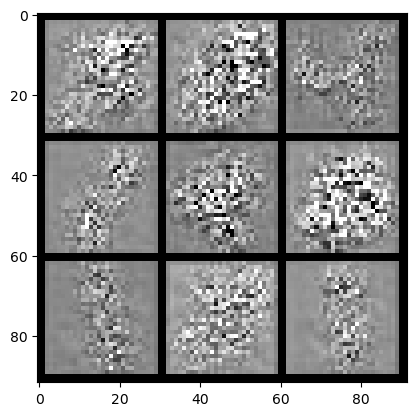

In [6]:
check_output = model_check.model(torch.tensor(X_train[0:9],dtype = torch.float32).reshape(9,1,28,28),torch.randint(0, max_timesteps, (9,)).long()).detach()

grid = torchvision.utils.make_grid((check_output+1.)/2., nrow = 3)
imshow(grid.numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


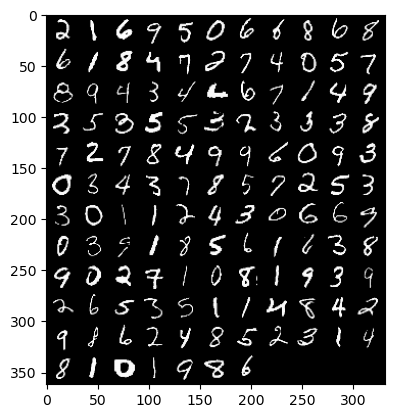

In [7]:
for j, (image, target) in enumerate(data_loader):
    if j == 0:
        grid = torchvision.utils.make_grid(image, nrow = 11)
        imshow(grid.numpy().transpose(1,2,0))
    break

In [8]:
epochs = 100
lr = 0.001
decay_ema = 0.995
ema_steps = 10
log_progress = 50
nb_samples = 36


model = MNISTDiffusion(img_size, img_channel, time_emb_dim=time_embedding_dim, max_timesteps=max_timesteps, base_channel= base_channel, channels_multiplier = mult_factors)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
loss_fn = nn.MSELoss(reduction='mean')
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, total_steps = epochs*len(data_loader), pct_start = 0.25, anneal_strategy = 'cos')

adjust = 1. * BS * ema_steps / epochs
alpha = 1.0 - decay_ema
alpha = min(1.0, alpha * adjust)

model_ema = ExponentialMovingAverage(model, device = device, decay = 1.0-alpha)


global_steps = 0
for i in range(epochs):
    model.train()
    pbar = tqdm(data_loader)
    for j, (image, target) in enumerate(pbar):
        noise = torch.randn_like(image).to(device)
        image = image.to(device)
        pred = model(image, noise)
        loss = loss_fn(pred, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        scheduler.step()
        if global_steps % ema_steps == 0:
            model_ema.update_parameters(model)

        if global_steps % log_progress == 0:
            pbar.set_description(f'Epoch: %.1f, step: %.1f,   loss: %.3f with learning rate %.6f' % (i,j,loss.detach().cpu().item(), scheduler.get_last_lr()[0]))
        global_steps += 1


    model_ema.eval()
    samples = model_ema.module.sampling(nb_samples, clipped_reverse_diffusion = True, device = device)
    save_image(samples, "results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(nb_samples)))
        
    

Epoch: 0.0, step: 450.0,   loss: 0.530 with learning rate 0.000044: 100%|██████████| 469/469 [07:00<00:00,  1.12it/s]
Sampling: 100%|██████████| 1000/1000 [01:16<00:00, 13.00it/s]
Epoch: 1.0, step: 431.0,   loss: 0.320 with learning rate 0.000054: 100%|██████████| 469/469 [06:41<00:00,  1.17it/s]
Sampling: 100%|██████████| 1000/1000 [00:50<00:00, 19.92it/s]
Epoch: 2.0, step: 462.0,   loss: 0.214 with learning rate 0.000073: 100%|██████████| 469/469 [06:45<00:00,  1.16it/s]
Sampling: 100%|██████████| 1000/1000 [00:50<00:00, 19.98it/s]
Epoch: 3.0, step: 443.0,   loss: 0.130 with learning rate 0.000098: 100%|██████████| 469/469 [06:39<00:00,  1.17it/s]
Sampling: 100%|██████████| 1000/1000 [01:08<00:00, 14.58it/s]
Epoch: 4.0, step: 424.0,   loss: 0.101 with learning rate 0.000128: 100%|██████████| 469/469 [08:56<00:00,  1.14s/it]
Sampling: 100%|██████████| 1000/1000 [01:11<00:00, 14.06it/s]
Epoch: 5.0, step: 455.0,   loss: 0.087 with learning rate 0.000169: 100%|██████████| 469/469 [08:53<

KeyboardInterrupt: 

In [8]:
epochs = 100
lr = 0.001
decay_ema = 0.995
ema_steps = 10
log_progress = 50
nb_samples = 36


model = MNISTDiffusion(img_size, img_channel, time_emb_dim=time_embedding_dim, max_timesteps=max_timesteps, base_channel= base_channel, channels_multiplier = mult_factors)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
loss_fn = nn.MSELoss(reduction='mean')
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, total_steps = epochs*len(data_loader), pct_start = 0.25, anneal_strategy = 'cos')

adjust = 1. * BS * ema_steps / epochs
alpha = 1.0 - decay_ema
alpha = min(1.0, alpha * adjust)

model_ema = ExponentialMovingAverage(model, device = device, decay = 1.0-alpha)

In [54]:
model_ema.eval()
samples = model_ema.module.sampling(36, device)

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.46it/s]


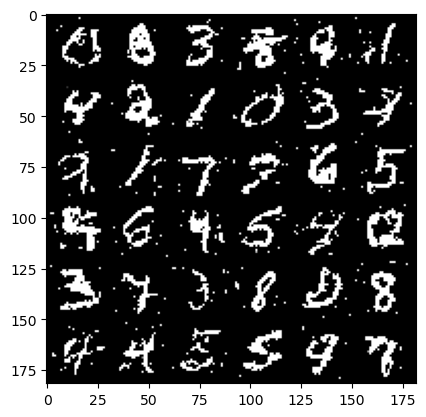

In [55]:

grid = torchvision.utils.make_grid(samples.detach().cpu(), nrow = 6)
imshow(grid.numpy().transpose(1,2,0))

In [58]:
save_image(grid, "inference_test.png",nrow=6)

In [13]:
model_ema.module.state_dict()

OrderedDict([('betas',
              tensor([4.1246e-05, 4.6253e-05, 5.1022e-05, 5.5850e-05, 6.0797e-05, 6.5684e-05,
                      7.0632e-05, 7.5340e-05, 8.0287e-05, 8.5115e-05, 9.0063e-05, 9.4771e-05,
                      9.9838e-05, 1.0461e-04, 1.0949e-04, 1.1438e-04, 1.1927e-04, 1.2410e-04,
                      1.2898e-04, 1.3387e-04, 1.3870e-04, 1.4359e-04, 1.4853e-04, 1.5336e-04,
                      1.5831e-04, 1.6302e-04, 1.6809e-04, 1.7285e-04, 1.7780e-04, 1.8251e-04,
                      1.8764e-04, 1.9240e-04, 1.9729e-04, 2.0224e-04, 2.0701e-04, 2.1195e-04,
                      2.1684e-04, 2.2167e-04, 2.2674e-04, 2.3150e-04, 2.3633e-04, 2.4140e-04,
                      2.4617e-04, 2.5117e-04, 2.5588e-04, 2.6101e-04, 2.6572e-04, 2.7072e-04,
                      2.7555e-04, 2.8056e-04, 2.8533e-04, 2.9039e-04, 2.9510e-04, 3.0017e-04,
                      3.0506e-04, 3.0994e-04, 3.1483e-04, 3.1978e-04, 3.2479e-04, 3.2955e-04,
                      3.3444e-04, 3.3

In [41]:
#torch.save(model_ema.state_dict(), 'model_ema_weights.pth')
model_ema.load_state_dict(torch.load('model_ema_weights.pth'))

<All keys matched successfully>

In [56]:
torch.save(model.state_dict(), 'model_weights.pth')
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.38it/s]


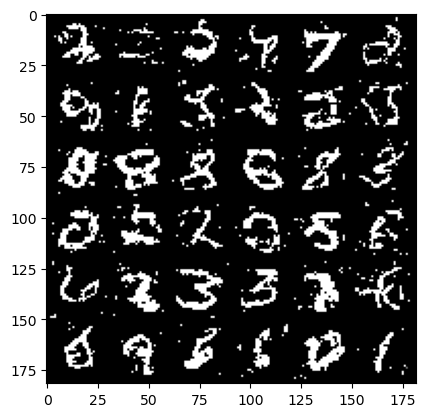

In [57]:
model.eval()
test_samples = model.sampling(36, device)

grid_test = torchvision.utils.make_grid(test_samples.detach().cpu(), nrow = 6)
imshow(grid_test.numpy().transpose(1,2,0))


In [59]:
save_image(grid_test, "inference_test2.png",nrow=6)